### **CSC_5RO13 TP5: Impact of RoI defect on the estimated pose**

When you create the colab session don't forget to modify the type of execution to use a GPU **(NOT A TPU)**!.

### **Practical session**

In this practical session, we will study the PViT-6D architecture (https://arxiv.org/abs/2311.17504) that we study during the course. This regression architecture, as of a lot of new pose estimators, works as a two-step architecture. Firstly an object detector detects our object of interest: here an toy ape. This object detector predicts a Region of Interest (RoI). Secondly, the actual pose estimators is used, which predicts the 6D pose directly from this RoI.

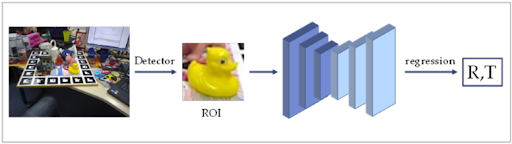


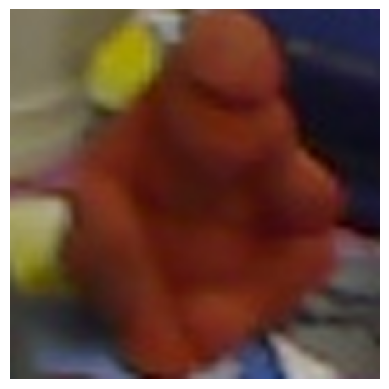

The performance of the object detector is then very important, as the detected RoI is the input of the pose estimator. The focus of this practical session will be to examine the impact of different defect of the RoI on the pose estimator.

Firstly, we will implement the postprocess of the PViT-6D, then we will implement different defects of the RoI.

### **Lets first download the LMO dataset and define some basics functions**

***Don't forget to also put in the colab all the XXX.py files and the onnx file !  ***

In [ ]:
!wget https://huggingface.co/datasets/bop-benchmark/datasets/resolve/main/lm/lm_test_bop19.zip
!unzip -d test_LMO lm_test_bop19.zip

In [ ]:
!pip install opencv-python==4.9.0.80
!pip install onnxruntime-gpu

import cv2
import numpy as np
import torch
import onnxruntime
import matplotlib.pyplot as plt

from torchvision import transforms

def draw_axes(image, camera_matrix, pose, axis_length=0.1):
    """
    Dessine les axes d'un repère 3D projeté en 2D sur une image.

    Parameters:
        image (np.ndarray): Image en entrée.
        camera_matrix (np.ndarray): Matrice intrinsèque de la caméra.
        pose (tuple): Pose 3D sous forme (R, t), où R est la matrice de rotation (3x3)
                      et t est le vecteur de translation (3x1).
        axis_length (float): Longueur des axes en unités 3D.
    """
    axis_3d = np.array([
        [0, 0, 0],
        [axis_length, 0, 0],
        [0, axis_length, 0],
        [0, 0, axis_length]
    ], dtype=np.float32)
    R, t = pose
    rvec, _ = cv2.Rodrigues(R)

    # Projection des points 3D sur l'image
    points_2d, _ = cv2.projectPoints(axis_3d, rvec, t, camera_matrix, distCoeffs=None)
    points_2d = points_2d.reshape(-1, 2).astype(int)

    # Dessin des axes
    origin = tuple(points_2d[0])
    image = cv2.line(image, origin, tuple(points_2d[1]), (0, 0, 255), 2)  # Axe X en rouge
    image = cv2.line(image, origin, tuple(points_2d[2]), (0, 255, 0), 2)  # Axe Y en vert
    image = cv2.line(image, origin, tuple(points_2d[3]), (255, 0, 0), 2)  # Axe Z en bleu

    return image

def plot_triedres(image, camera_matrix, pose1, pose2, axis_length=0.1):
    """
    Affiche une image avec deux trièdres projetés dessus.

    Parameters:
        image (np.ndarray): Image en entrée.
        camera_matrix (np.ndarray): Matrice intrinsèque de la caméra.
        pose1 (tuple): Première pose 3D (R1, t1).
        pose2 (tuple): Deuxième pose 3D (R2, t2).
        axis_length (float): Longueur des axes des trièdres.
    """
    image_copy = image.copy()

    image_copy = draw_axes(image_copy, camera_matrix, pose1,  axis_length=200)
    image_copy = draw_axes(image_copy, camera_matrix, pose2, axis_length=200)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## **Introduction to the model**
We will load a lighter version of the model which has been quantized (you will learn a bit more about it on the next class!) , so as to be able to make faster inference with it. Keep in mind: quantization may impact the performance. Even if in our case, the loss in performance is minimal.

For the model we will use an ONNX model. "ONNX is an open format built to represent machine learning models. ONNX defines a common set of operators - the building blocks of machine learning and deep learning models - and a common file format to enable AI developers to use models with a variety of frameworks, tools, runtimes, and compilers."

So as to use an ONNX model, we've got to create a session which can use either the CPU or CUDA.

First of all, we can familariaze ourselves with all the input the model needs:
1.   An object class
2.   A Region of Interest, which has been infered by an object detector or is the ground turth (our case)
3.   The bounding box (center x, center y, w, h)

All the inputs are gathered in a dictionnary, with a specific name! A random input will be used to see what is the output of the model.

In [ ]:
model_path = '/content/PViT6D_lmo_fp16.onnx'
session = onnxruntime.InferenceSession(model_path, providers=['CUDAExecutionProvider'])

inputs_name = [elt.name for elt in session.get_inputs()]
print(f"Inputs names: {inputs_name}")
inputs_shape = [elt.shape for elt in session.get_inputs()]
print(f'Inputs shapes: {inputs_shape}')
inputs_type = [elt.type for elt in session.get_inputs()]
print(f'Inputs types: {inputs_type}')
input_tensor = torch.zeros(3,224,224).unsqueeze(0).numpy()
print(f'Input tensor is of size {input_tensor.shape} and type {input_tensor.dtype}')
bbox_normalized = np.array([0.2,0.2,0.2,0.2], dtype=np.float32)


output = session.run(None,{'input.1':np.array([0]),'input.3': input_tensor, 'onnx::MatMul_7': bbox_normalized[np.newaxis,np.newaxis,:]}) #RoI cls / RoI image / bbox
print(f'The raw output of the model is: {output}')

## **Post process**
As we can see the models output delta for the translation vectors (3x1) and a 3x2 matrice for the rotation. However, we would like to have the translation vector between the camera and the object and the full rotation matrix (3x3)

In this section, you will have to implement all the postprocesses depicted in the PViT6D article. The main body part of the postprocess function is given, the XXXXXXX should be replaced by your code.

In [ ]:
import torch
import torch.nn.functional as F
from pose_utils_student import allo_to_ego_mat_torch

def postprocess(preds, bbox): #bbox -> cx,cy,w,h
        cams = torch.tensor([[572.4114, 0, 325.2611],
                              [0, 573.57043, 242.04899],
                              [0, 0, 1]], dtype=torch.float32)
        diameter = 102.099 / 1000 #ONLY FOR THE APE
        pred_rot_ = preds[0]
        pred_t_ = preds[1]
        s_box = XXXXXX
        z_type = 'rel'
        rot_type = 'allo_rot6d'

        pred_rot_ = torch.tensor(pred_rot_)
        pred_t_ = torch.tensor(pred_t_)
        bbox = torch.tensor(bbox)

        ### Resize ratio calcul
        focal_length = cams[0, 0] if bbox[2] > bbox[3] else cams[1, 1]
        resize_ratios = XXXXXX

        ### From R6D to the full matrice 3x3
        x_raw = pred_rot_[..., 0:3]  # bx3
        y_raw = pred_rot_[..., 3:6]  # bx3
        x = XXXXXX # bx3
        z = XXXXXX # bx3
        z = XXXXXX # bx3
        y = XXXXXX # bx3

        # (*,3)x3 --> (*,3,3)
        pred_rot_m  = XXXXXX  # (b,3,3)

        pred_centroids=pred_t_[:, :2]
        pred_z_vals=pred_t_[:, 2:3]
        roi_whs= torch.tensor([s_box,s_box])[np.newaxis, :]
        roi_centers=bbox[:2][np.newaxis, :]
        cams.unsqueeze_(0)

        c = torch.stack(
          [
              XXXXXX, #bx1
              XXXXXX, #bx1
          ],
          dim=1,
        ) #bx2

        cx = c[:, 0:1]
        cy = c[:, 1:2]

        z = pred_z_vals * resize_ratios.view(-1, 1)

        # backproject regressed centroid with regressed z
        translation = torch.cat(
          [
              XXXXXX ,#bx1
              XXXXXX ,#bx1
              XXXXXX ,#bx1
          ],
          dim=1,
      ) #bx3

        # from allocentric to egocentric reprensentation
        if pred_rot_m.ndim == 3 and pred_rot_m.shape[-1] == 3:  # bx3x3
            rot_ego = allo_to_ego_mat_torch(translation, pred_rot_m, eps=1e-4)

        preds_dict = {"rot": rot_ego, "trans": translation, "pred_t_": pred_t_}
        return preds_dict

In [ ]:
bbox = bbox_normalized
prediction_dict = postprocess(output, bbox)
print(f"Rotation matrix predicted:\n{prediction_dict['rot']}\nTranslation vector predicted (in mm):\n{prediction_dict['trans']}\n")

## **Lets work on actual data!**

In [ ]:
import json
image_dir = 'test_LMO/test/000001/rgb'
scene_gt_path = 'test_LMO/test/000001/scene_gt.json'
scene_gt_info_path = 'test_LMO/test/000001/scene_gt_info.json'

with open(scene_gt_path, 'r') as f:
    scene_gt = json.load(f)

with open(scene_gt_info_path, 'r') as f:
    scene_gt_info = json.load(f)

## **Inference**

In [ ]:
from functools import partial
import numpy as np
import os
from tqdm import tqdm
from pose_metrics import PoseMetrics
import matplotlib.pyplot as plt
from pose_utils_student import preprocess
from bbx import xywh2cxcywh


metrics = PoseMetrics(
                save_dir='',
                model_pts=None,
                class_names = {0: 'ape'},
                diameters={0:102.099},
                binary_symmetries={0:None})

visu=True

for img_id in tqdm(range(10), desc="Processing images"):
    img_name = f"{img_id:06d}.png"
    img_path = os.path.join(image_dir, img_name)

    image = cv2.imread(img_path)
    if image is None:
        continue

    obj_annotations = scene_gt[str(img_id)]
    bbox_info = scene_gt_info[str(img_id)]

    for obj_idx, obj_data in enumerate(obj_annotations):
        obj_id = obj_data['obj_id']
        if obj_id != 1:
            continue

        # Récupérer la bbox visible
        bbox = np.array(bbox_info[obj_idx]['bbox_visib'], dtype=np.float32)
        bbox = xywh2cxcywh(bbox) #bbox was top_left_x,top_left_y,size_x,size_y



        ### Implement here all your defect on the bbox, don't forget the bbox is cx,cy,w,h




        bbox = np.array(bbox, dtype=np.float32)
        RoI, bbox_normalized = preprocess(image, bbox, verbose=True) #BGR image, bbox: cx,cy,w,h !
        output = session.run(None, {
            'input.1': np.array([0]),  # Classe
            'input.3': np.array(RoI),  # Image
            'onnx::MatMul_7': np.array(bbox_normalized, dtype=np.float32)[np.newaxis,np.newaxis, :]  # Bbox
        })
        prediction_dict = postprocess(output, bbox)


        if visu:
          camera_matrix = np.array([[572.4114, 0, 325.2611],
                              [0, 573.57043, 242.04899],
                              [0, 0, 1]])
          plot_triedres(image, camera_matrix, (np.array(obj_data["cam_R_m2c"]).reshape(3,3), np.array(obj_data["cam_t_m2c"])), (np.array(prediction_dict["rot"]).reshape(3,3), np.array(prediction_dict["trans"]*1000)))

        metrics.update(
            pred_trans=torch.tensor(prediction_dict["trans"]*1000), #we predict in meters, but everything works with mm
            pred_rot=torch.tensor(prediction_dict["rot"]),
            gt_trans=torch.tensor(obj_data["cam_t_m2c"]).unsqueeze(0),
            gt_rot=torch.tensor(obj_data["cam_R_m2c"]).reshape(3, 3).unsqueeze(0),
            gt_cls=torch.tensor([0]),  #corresponding class
            pred_scores=prediction_dict.get("pred_scores", None),
            name_img=[img_path]
        )

# Summary of the result (every metrics you can use)
print(f'Nb:{metrics.num_targets} avg_trans_distance: {metrics.avg_trans_distance:04f}mm, avg_ang_distance: {metrics.avg_ang_distance:04f}°')
print(f'{metrics.ang_distances_cls}')
print(f'{metrics.trans_distances_cls}')
print(f'{metrics.trans_distances_cls_non_abs}')
print(f'{metrics.x_distances_cls_non_abs}')
print(f'{metrics.y_distances_cls_non_abs}')
print(f'{metrics.z_distances_cls_non_abs}')

## Your contribution !
Let's implement some possible errors of the bounding box. Don't hesitate to ask questions, and present your ideas / results.

Little advice a heatmap to show the error using differents values of each error is a nice way to show how the model is perturbated by your defects!

Don't forget to put a 1000 images in the for loop!